Ejemplo para la clase de inteligencia artificial, Universidad del Magdalena. Este ejemplo está construido con el conjunto de datos Wine Quality, la cual fue descargdada de https://www.kaggle.com/datasets/rajyellow46/wine-quality?rvi=1. El objetivo del ejemplo es ilustrar distintos tipos de regresión para predecir la calidad del vino con base en ciertas características físico químicas.

In [138]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [139]:
wineData = pd.read_csv('winequalityN.csv')
wineData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6497 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  6497 non-null   object 
 1   fixed acidity         6487 non-null   float64
 2   volatile acidity      6489 non-null   float64
 3   citric acid           6494 non-null   float64
 4   residual sugar        6495 non-null   float64
 5   chlorides             6495 non-null   float64
 6   free sulfur dioxide   6497 non-null   float64
 7   total sulfur dioxide  6497 non-null   float64
 8   density               6497 non-null   float64
 9   pH                    6488 non-null   float64
 10  sulphates             6493 non-null   float64
 11  alcohol               6497 non-null   float64
 12  quality               6497 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 660.0+ KB


# Inspección de los datos

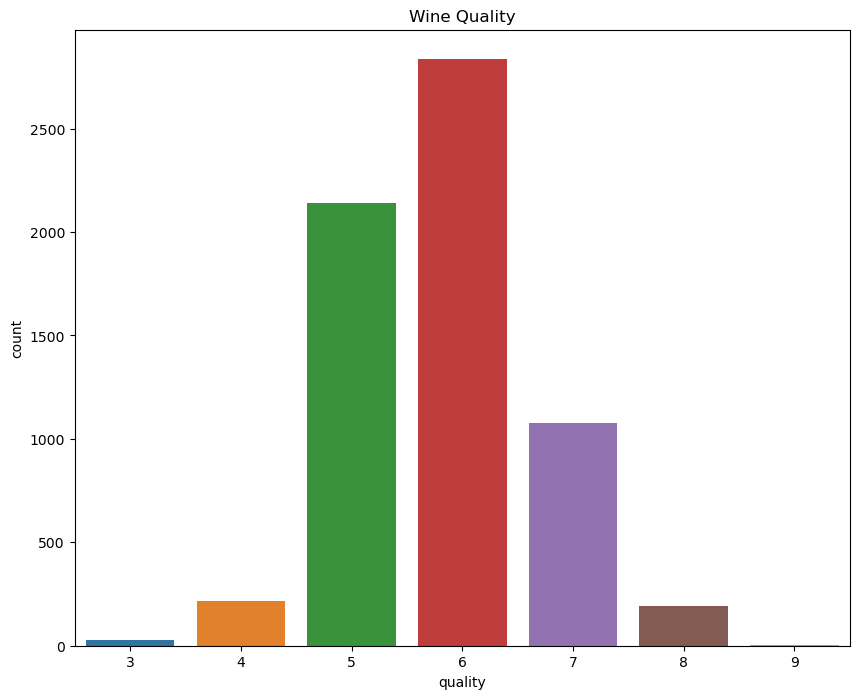

In [140]:
#Diagrama de barras del atributo clase
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(x='quality',data=wineData)
plt.title("Wine Quality")
plt.show()

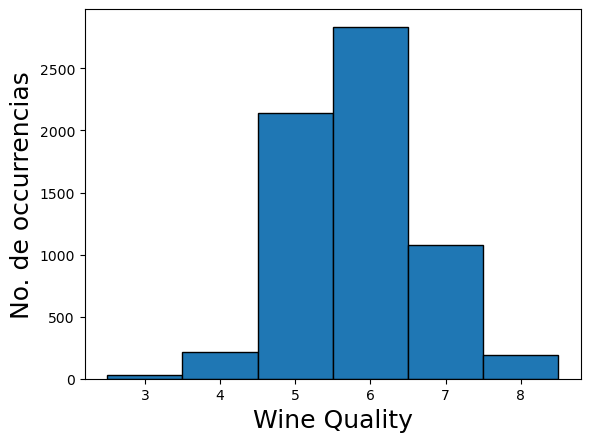

In [141]:
plt.hist(wineData.quality.values,bins=[2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5],edgecolor = 'black')
plt.xlabel('Wine Quality', fontsize = 18)
plt.ylabel('No. de occurrencias', fontsize = 18)
plt.show()

Revisando si hay valores faltantes

In [142]:
wineData.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

Conversión de una variable categórica a numérica. Esto es necesario para utilizar el método de rellenado de datos faltantes que sigue a continuación.

In [143]:
wine_types = pd.get_dummies(wineData['type'])
wineData = wineData.drop('type',axis=1) #Elimina la variable State de X, y se queda con las nuevas variables creadas por cada categoría
wineData = pd.concat([wineData, wine_types],axis=1)

print(wineData.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  quality    red  white  
0      8.8        6  False   True  
1      9.5    

Rellenando datos faltantes con KNNImputer

In [144]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
wineData = pd.DataFrame(imputer.fit_transform(wineData), columns=wineData.columns)
wineData.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
red                     0
white                   0
dtype: int64

Inspeccionando la distribución de los valores de las variables predictoras.

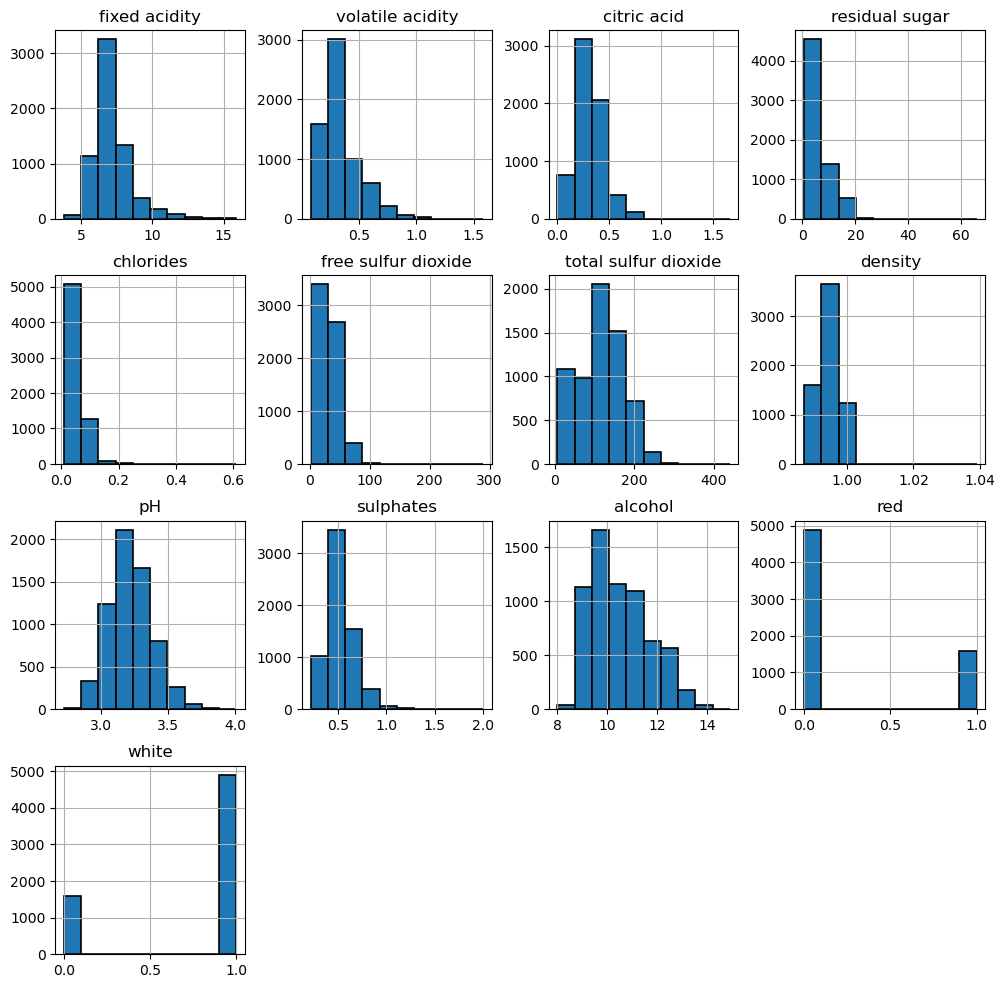

In [145]:
X = wineData.drop('quality', axis=1)
X.hist(edgecolor='black', linewidth=1.2)
fig=plt.gcf()
fig.set_size_inches(12,12)
plt.show()

Se utiliza correlación de Spearman por la posibilidad de no contar con variables normalmente distribuidas.

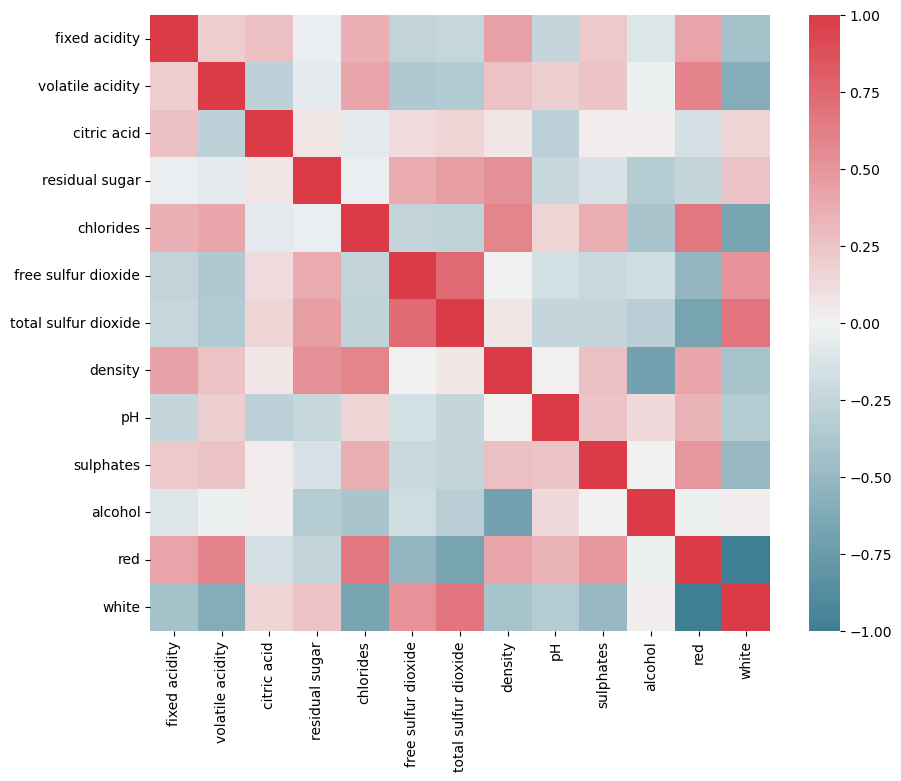

In [158]:
f, ax = plt.subplots(figsize=(10, 8))
corr = X.corr(method='spearman')
sns.heatmap(corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), ax=ax)
plt.show() 

In [162]:
def corr_feature_detect(data, threshold):
     
    corrmat = data.corr()
    corrmat = corrmat.abs().unstack() # absolute value of corr coef
    corrmat = corrmat.sort_values(ascending=False)
    corrmat = corrmat[corrmat >= threshold]
    corrmat = corrmat[corrmat < 1] # remove the digonal
    corrmat = pd.DataFrame(corrmat).reset_index()
    corrmat.columns = ['feature1', 'feature2', 'corr']
   
    grouped_feature_ls = []
    correlated_groups = []
    
    for feature in corrmat.feature1.unique():
        if feature not in grouped_feature_ls:
    
            # find all features correlated to a single feature
            correlated_block = corrmat[corrmat.feature1 == feature]
            grouped_feature_ls = grouped_feature_ls + list(
                correlated_block.feature2.unique()) + [feature]
    
            # append the block of features to the list
            correlated_groups.append(correlated_block)
    return correlated_groups


In [163]:
corr = corr_feature_detect(data=X,threshold=0.95)
for i in corr:
    print(i,'\n')
if len(corr) == 0:
    print('No hay variables correlacionadas')

# Regresión lógistica y SoftMax

Primero se escalan todas las variables numéricas.

In [125]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = wineData['quality'] 

Primero trataremos el problema como un problema de clasificación multiclase, esto es equivalente a SoftMax regresión.

In [126]:
#Hay que dividir el cojunto de datos en entrenamiento y prueba
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [127]:
softReg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs',  max_iter=500)
softReg.fit(X_train,y_train)

LogisticRegression(max_iter=500, multi_class='multinomial')

Evaluemos el modelo resultante con los mismos datos utilizados para entrenar.

In [128]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
y_train_predicted_softReg = softReg.predict(X_train)
print(accuracy_score(y_train, y_train_predicted_softReg))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_train, y_train_predicted_softReg))

0.5458544095007697
Confusion matrix:
[[   0    0   10   10    0    0    0]
 [   0    7   84   54    1    0    0]
 [   0    6  894  593    9    0    0]
 [   0    0  447 1414  119    0    0]
 [   0    0   56  542  167    0    0]
 [   0    0   13   89   30    0    0]
 [   0    0    0    1    1    0    0]]


Evaluemos ahora con los datos reservados para la prueba:

In [129]:
y_test_predicted_softReg = softReg.predict(X_test)
print(accuracy_score(y_test, y_test_predicted_softReg))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_test_predicted_softReg))

0.5317948717948718
Confusion matrix:
[[  0   3   3   3   0   1   0]
 [  0   4  39  27   0   0   0]
 [  0   0 380 254   2   0   0]
 [  0   0 214 592  50   0   0]
 [  0   0  19 234  61   0   0]
 [  0   0   3  41  17   0   0]
 [  0   0   0   0   3   0   0]]


### Regresión Lógistica

Como se puede observar el cojunto de datos está dividido en multiples clases que están desbalanceadas en el número de ejemplos existentes para cada clase. Por lo tanto, vamos a hacer una categorización de los vinos en dos clases de acuerdo a su calidad.

In [130]:
wineData['category'] = np.where(wineData['quality'] >= 6,'G1', 'G2')
wineData.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,red,white,category
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6.0,0.0,1.0,G1
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6.0,0.0,1.0,G1
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6.0,0.0,1.0,G1
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0,0.0,1.0,G1
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6.0,0.0,1.0,G1


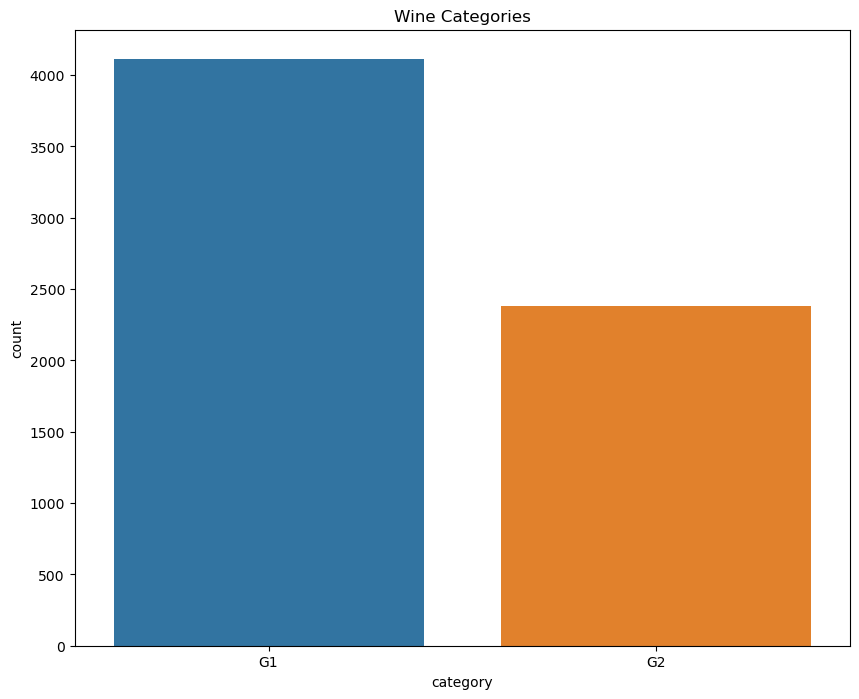

In [131]:
ax=plt.subplots(1,1,figsize=(10,8))
sns.countplot(x='category',data=wineData)
plt.title("Wine Categories")
plt.show()

Particionamos nuevamente el conjunto de datos que ha sido reclasificado.

In [132]:
y = wineData['category']
X = wineData.drop(['category','quality'], axis=1)
X = scaler.fit_transform(X)
y = wineData['category'] 

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [134]:
logReg = LogisticRegression()
logReg.fit(X_train, y_train)
logReg.coef_, logReg.intercept_ 

(array([[-0.10468   ,  0.80072997,  0.02117593, -0.53588352,  0.03260394,
         -0.3125652 ,  0.35826455,  0.37454869, -0.14265343, -0.27280081,
         -1.03438217, -0.13980268,  0.13980268]]),
 array([-0.77681263]))

In [135]:
y_train_predicted_logReg = logReg.predict(X_train)
print(accuracy_score(y_train, y_train_predicted_logReg))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_train, y_train_predicted_logReg))

0.7475258412139872
Confusion matrix:
[[2462  450]
 [ 698  937]]


In [136]:
y_test_predicted_logReg = logReg.predict(X_test)
print(accuracy_score(y_test, y_test_predicted_logReg))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, y_test_predicted_logReg))

0.718974358974359
Confusion matrix:
[[979 222]
 [326 423]]
